In [10]:
!pip install -q rhino3dm shapely trimesh matplotlib pyvista



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


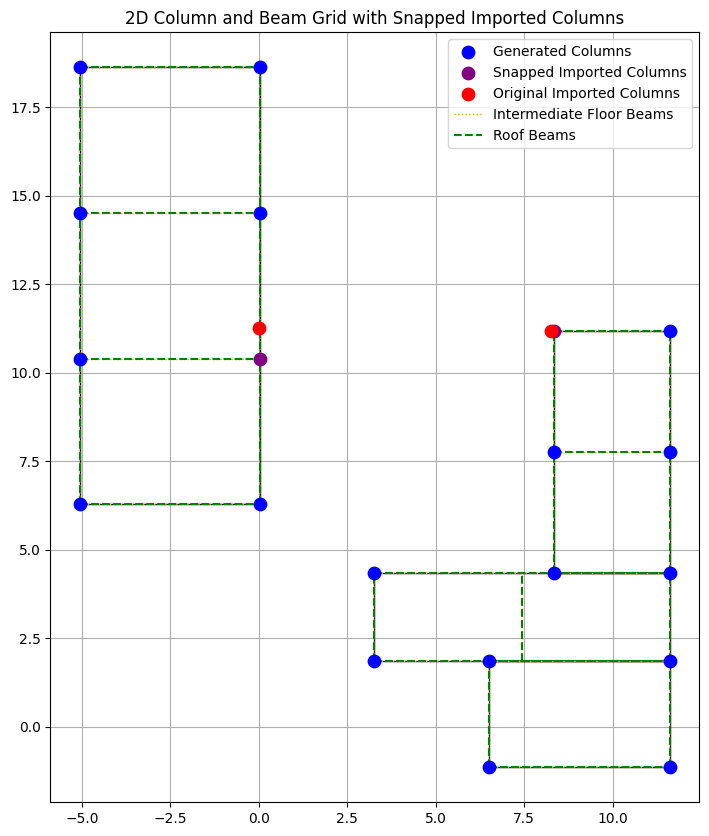

AttributeError: 'rhino3dm._rhino3dm.BrepFace' object has no attribute 'ClosestPoint'

In [ ]:
# DONT TOUCH

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}  # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))  # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_exact_surface_height(x, y, brep, search_radius=1.0):
    """
    Approximates Z value at (x, y) on brep surface by checking closest vertex in the brep's mesh.
    """
    point = np.array([x, y])
    closest_z = None
    min_dist = float('inf')

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for v in mesh.Vertices:
            vx, vy, vz = v.X, v.Y, v.Z
            dist = np.linalg.norm(point - np.array([vx, vy]))
            if dist < min_dist and dist < search_radius:
                min_dist = dist
                closest_z = vz

    return closest_z




# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                       radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04  # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt)
    if not brep:
        continue  # Skip if this room has no brep

    local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': brep.GetBoundingBox()}]

    h1 = get_wall_height(x1, y1, local_wall_data)
    h2 = get_wall_height(x2, y2, local_wall_data)

    for floor in range(1, num_floors + 1):
        if floor == num_floors:
            z1 = h1
            z2 = h2
        else:
            # Calculate ideal beam height fractionally
            # Sample the real Z at the beam's X,Y location for this floor
            roof_z1 = get_exact_surface_height(x1, y1, brep)
            roof_z2 = get_exact_surface_height(x2, y2, brep)

            if roof_z1 is None or roof_z2 is None:
                continue  # skip if surface not defined

            zi1 = roof_z1 * floor / num_floors
            zi2 = roof_z2 * floor / num_floors


            # Clip height to the actual surface (roof or wall)
            z1 = min(zi1, roof_z1)
            z2 = min(zi2, roof_z2)


            # Optional: if the entire beam is above both points, skip
            if zi1 > h1 and zi2 > h2:
                continue


        start = np.array([x1, y1, z1])
        end = np.array([x2, y2, z2])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2

        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)




# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

In [ ]:
import pandas as pd
from collections import OrderedDict

# --- 1. Collect Unique Nodes ---
node_coords = []
node_dict = OrderedDict()
node_counter = 0

def add_node(pt):
    key = tuple(np.round(pt, 5))  # reduce float precision issues
    if key not in node_dict:
        node_id = f"N{len(node_dict)}"
        node_dict[key] = node_id
        node_coords.append([node_id] + list(key))
    return node_dict[key]

# --- 2. Create Column & Beam Connections ---
column_lines = []
beam_lines = []

for x, y in all_base_columns:
    roof_height = intersect_with_roof_brep(x, y, wall_breps)
    if roof_height is None:
        roof_height = get_wall_height(x, y, wall_breps)  # fallback
    
    cylinder = pv.Cylinder(center=(x, y, roof_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=roof_height)
    plotter.add_mesh(cylinder, color='blue')



for (x1, y1), (x2, y2) in beams:
    pt1 = (x1, y1, max_z)
    pt2 = (x2, y2, max_z)
    id1 = add_node(pt1)
    id2 = add_node(pt2)
    beam_lines.append((id1, id2))

# --- 3. Export nodes.csv ---
df_nodes = pd.DataFrame(node_coords, columns=["ID", "X", "Y", "Z"])
df_nodes.to_csv("nodes4.csv", index=False)
print("✅ nodes.csv written.")

# --- 4. Export columns.csv ---
col_data = []
for i, (i_node, j_node) in enumerate(column_lines):
    p1 = df_nodes[df_nodes["ID"] == i_node][["X", "Y", "Z"]].values[0]
    p2 = df_nodes[df_nodes["ID"] == j_node][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2 - p1)
    col_data.append([f"C{i}", i_node, j_node, round(length, 3)])

df_cols = pd.DataFrame(col_data, columns=["ID", "i_node", "j_node", "length"])
df_cols.to_csv("columns4.csv", index=False)
print("✅ columns.csv written.")

# --- 5. Export beams.csv ---
beam_data = []
for i, (i_node, j_node) in enumerate(beam_lines):
    p1 = df_nodes[df_nodes["ID"] == i_node][["X", "Y", "Z"]].values[0]
    p2 = df_nodes[df_nodes["ID"] == j_node][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2 - p1)
    beam_data.append([f"B{i}", i_node, j_node, round(length, 3)])

df_beams = pd.DataFrame(beam_data, columns=["ID", "i_node", "j_node", "length"])
df_beams.to_csv("beams4.csv", index=False)
print("✅ beams.csv written.")


✅ nodes.csv written.
✅ columns.csv written.
✅ beams.csv written.


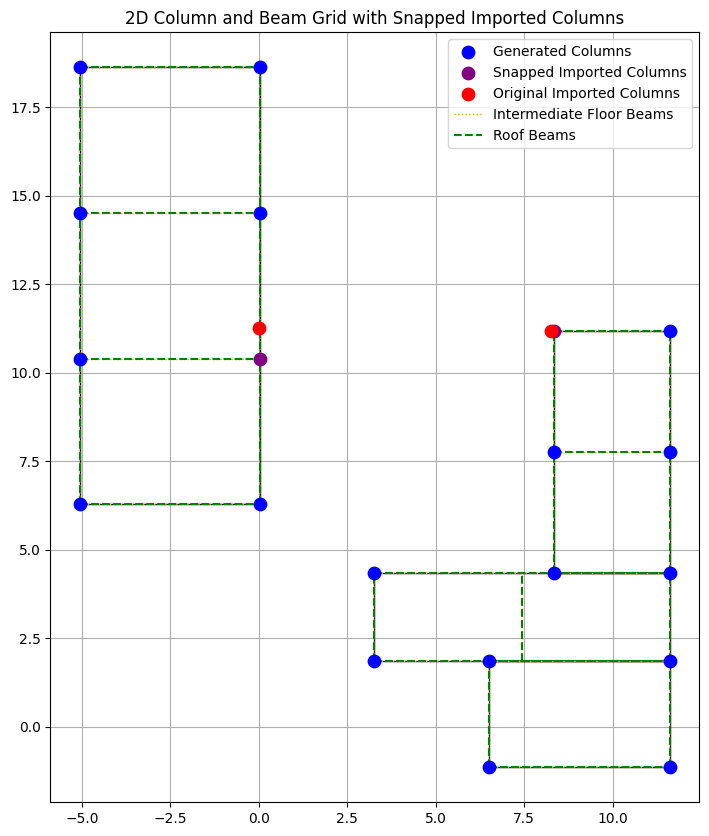

Widget(value='<iframe src="http://localhost:62719/index.html?ui=P_0x1c4f6cde0d0_1&reconnect=auto" class="pyvis…

In [2]:
# DONT TOUCH

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None


for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if not mesh:
                continue

            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            dist = poly.exterior.distance(Point(x, y))
            if dist < search_radius:
                return wall['bbox'].Max.Z
        return max_z

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                       radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04  # thinner than column radius 0.1

for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, wall_breps)
    h2 = get_wall_height(x2, y2, wall_breps)
    floor_height = min(h1, h2)

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height (important for cantilevers or partial-height volumes)
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)



# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

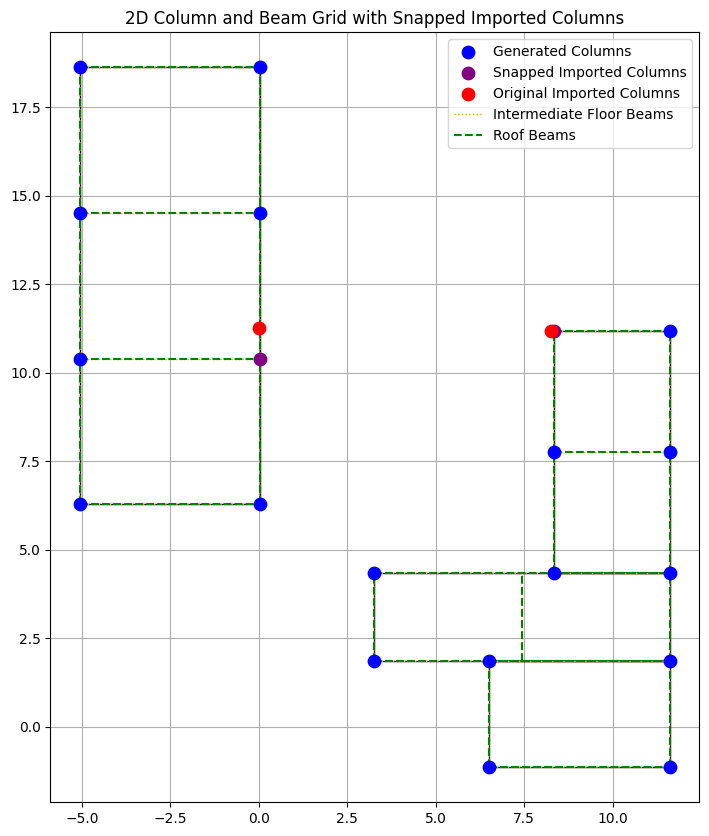

Widget(value='<iframe src="http://localhost:62719/index.html?ui=P_0x1c4815f3610_4&reconnect=auto" class="pyvis…

In [8]:
# DONT TOUCH

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}  # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))  # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if not mesh:
                continue

            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            dist = poly.exterior.distance(Point(x, y))
            if dist < search_radius:
                return wall['bbox'].Max.Z
        return max_z

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                       radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04  # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt)
    if not brep:
        continue  # Skip if this room has no brep

    local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': brep.GetBoundingBox()}]

    h1 = get_wall_height(x1, y1, local_wall_data)
    h2 = get_wall_height(x2, y2, local_wall_data)

    for floor in range(1, num_floors + 1):
        if floor == num_floors:
            # Roof beam: follow actual sloped height
            z1 = h1
            z2 = h2
        else:
            # Intermediate beams: flat at fraction of height
            z1 = h1 * floor / num_floors
            z2 = h2 * floor / num_floors

        # Skip beams above wall height
        if z1 > h1 and z2 > h2:
            continue

        start = np.array([x1, y1, z1])
        end = np.array([x2, y2, z2])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2

        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)




# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()